# Data Cleaning
This Data cleaning process has been done by thoroughly analyzing the 3 EDA Notebooks and finding patterns or important insights that hint into the necessity of data cleaning.

**Goal:** The primary objective is to prepare a high-quality dataset for cardiovascular disease prediction by removing biologically implausible values, correcting measurement errors, and engineering clinically meaningful features like BMI and pulse pressure. By systematically cleaning outliers in height, weight, and blood pressure, we aim to reveal the true statistical relationships between features and the target variable (`cardio`). This ensures that downstream machine learning models are trained on reliable data, improving both accuracy and interpretability of predictions.

# Step 0 – Load the Dataset and Inspect Initial Structure

We start by loading the Kaggle Cardiovascular Disease dataset and doing an initial inspection.  
This gives us a baseline to compare all future transformations.  

From our earlier EDA PDFs, we already know:
- The dataset has ~70k rows and 13 columns.
- No missing values initially.
- Data types look consistent but contain clear *outliers* and *encoding issues*.


In [433]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw
df_raw = pd.read_csv("../data/raw/cardio_train.csv", sep=';')

# Working copy
df = df_raw.copy()

print(df_raw.shape)
df_raw.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


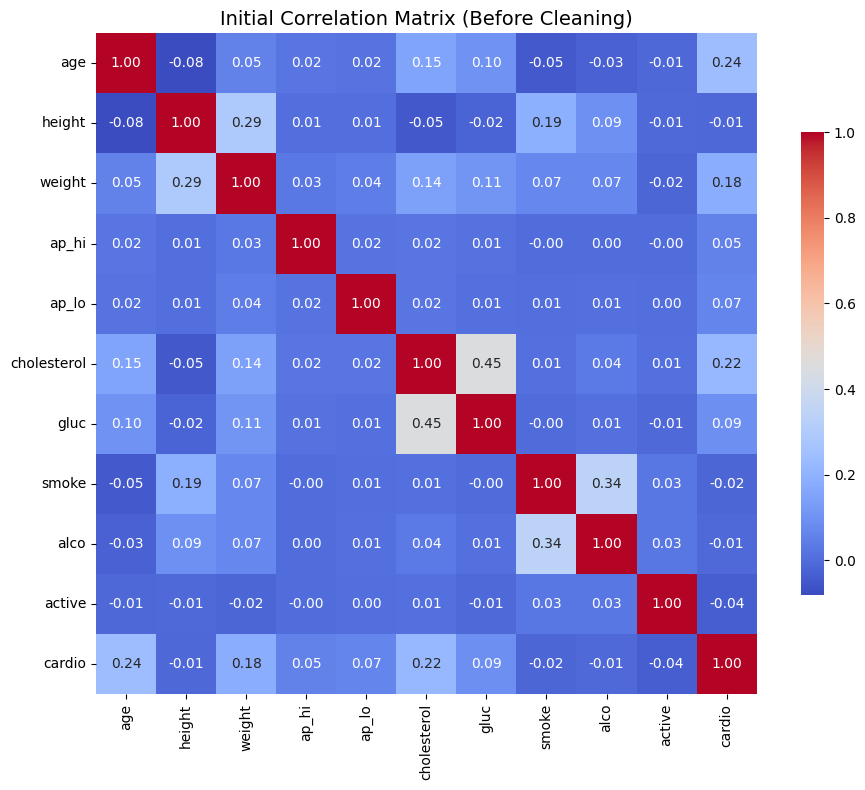


Initial correlations with cardio:

cardio         1.000000
age            0.238159
cholesterol    0.221147
weight         0.181660
gluc           0.089307
ap_lo          0.065719
ap_hi          0.054475
alco          -0.007330
height        -0.010821
smoke         -0.015486
active        -0.035653
Name: cardio, dtype: float64


In [434]:
import seaborn as sns

# Compute initial correlation matrix (before any cleaning)
# Note: 'age' is still in days, 'id' is still present
initial_corr_features = [
    'age', 'height', 'weight',
    'ap_hi', 'ap_lo',
    'cholesterol', 'gluc',
    'smoke', 'alco', 'active', 'cardio'
]

initial_corr_matrix = df_raw[initial_corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    initial_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.7}
)
plt.title("Initial Correlation Matrix (Before Cleaning)", fontsize=14)
plt.tight_layout()
plt.show()

print("\nInitial correlations with cardio:\n")
print(initial_corr_matrix['cardio'].sort_values(ascending=False))

This initial correlation matrix shows relationships between variables **before any cleaning**. Note that:
- `age` is still in days (not years)
- BMI and pulse pressure (`pp`) have not been computed yet
- Outliers in height, weight, and blood pressure are still present

We will compare this to the final correlation matrix after cleaning to see how data quality improvements affect the relationships.

# Step 1 – Remove the ID column and Convert Age from Days to Years

The `id` column is a unique identifier and brings no predictive value — it could even introduce data leakage in models.  
The `age` column is given in **days**, which is not interpretable for medical or statistical analysis.  
We convert it to integer **years**, improving interpretability and comparability with clinical standards.


### Why converting age to integer years makes sense

Using age in whole years instead of days improves interpretability and aligns with how age is commonly recorded and analyzed in real-world datasets, especially for descriptive statistics and visualization. Andrade et al. (2017) explain that treating age in discrete units is often appropriate when the goal is clarity and practical interpretation rather than fine-grained physiological precision.  
Source: [Age as a variable: Continuous or categorical?](https://pmc.ncbi.nlm.nih.gov/articles/PMC5806344/)


We will visualize the age distribution before and after conversion to confirm that the transformation preserves shape.


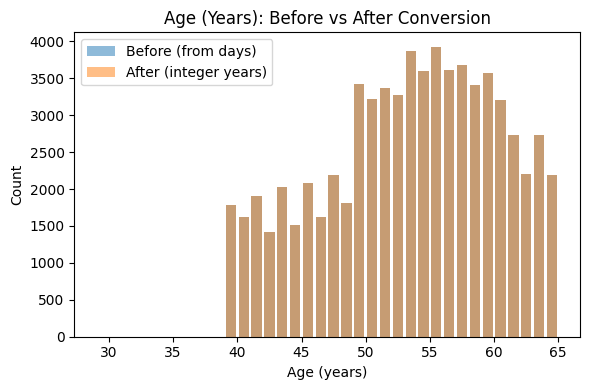

In [435]:
import numpy as np
import matplotlib.pyplot as plt

# Keep a copy before transformation
df_step0 = df.copy()

# Convert
if 'id' in df.columns:
    df = df.drop(columns=['id'])
df['age_years'] = (df['age'] / 365).astype(int)
df = df.drop(columns=['age'])

# Use integer bins for consistent visualization
bins = np.arange(29, 66, 1)

# -----------------------------
# COMBINED BEFORE vs AFTER PLOT
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(df_step0['age'] / 365, bins=bins, alpha=0.5, rwidth=0.8, label="Before (from days)")
ax.hist(df['age_years'], bins=bins, alpha=0.5, rwidth=0.8, label="After (integer years)")

ax.set_title("Age (Years): Before vs After Conversion")
ax.set_xlabel("Age (years)")
ax.set_ylabel("Count")
ax.legend()

plt.tight_layout()
plt.show()

This plot shows the effect of converting age from days to integer years. The “before” and “after” histograms almost perfectly overlap, meaning the conversion did not change the overall age distribution. The vertical bars represent exact counts per integer age after discretization. This confirms that only rounding was applied without distorting the data.


# Step 2 – Clean Height, Weight, and Calculate BMI

From our EDA, we noticed biologically impossible values:
- Heights as low as 55 cm and above 250 cm
- Weights under 30 kg or above 200 kg  

Such entries distort statistics and model relationships.

We first remove rows from height and weight violating realistic adult threshhold:
- `140 ≤ height ≤ 210`
- `30 ≤ weight ≤ 200`

## BMI

Body Mass Index (BMI) is a widely used indicator to assess body weight relative to height and to identify underweight, overweight, and obesity at the population level. Cleaning height and weight before computing BMI, and removing implausible BMI values afterward, improves data validity and prevents extreme measurement errors from distorting analyses.  
Source: [World Health Organization – BMI Classification](https://www.who.int/data/gho/data/themes/theme-details/GHO/body-mass-index-(bmi))


We compute the **Body Mass Index (BMI)** as 
`Weight / (Height / 100) ^ 2`

Then we remove unrealisticly values from BMI
- `15 ≤ BMI ≤ 60`

These limits capture the full adult physiological range while discarding clearly corrupted entries.

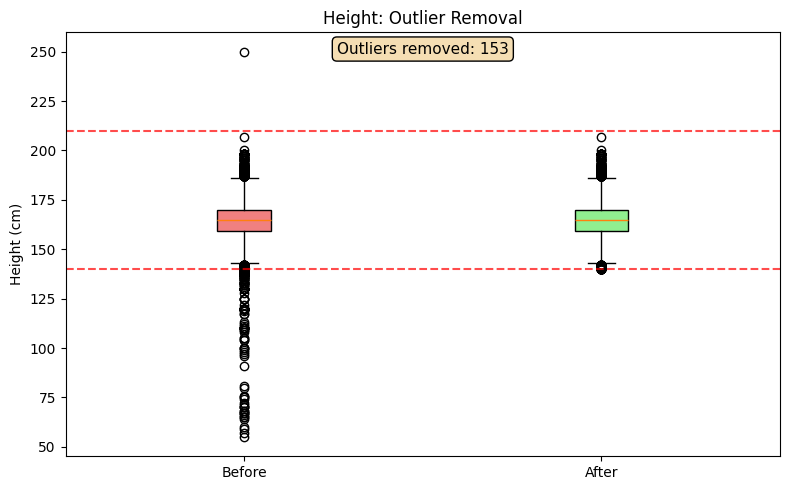

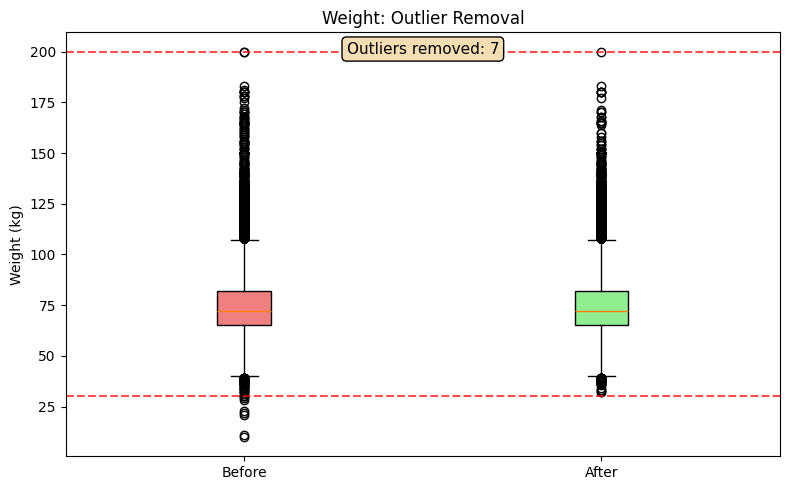

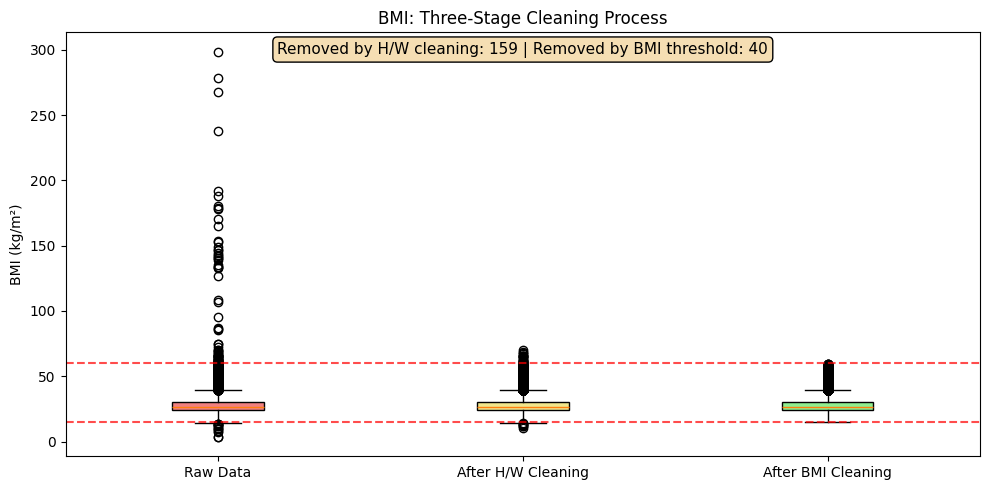

STEP 2 SUMMARY
Rows before: 70,000
Rows after:  69,801
Total rows removed: 199
Percentage removed: 0.28%

Columns before: 12
Columns after:  13
New column added: BMI


In [436]:

# -----------------------------
# STEP 1: Keep original copy
# -----------------------------
df_step1 = df.copy()
df_step1_untouched = df_step1.copy()

# Compute BMI on raw data
df_step1['BMI'] = df_step1['weight'] / (df_step1['height'] / 100) ** 2

# -----------------------------
# CLEAN HEIGHT & WEIGHT FIRST
# -----------------------------
mask_hw = (
    df['height'].between(140, 210) &
    df['weight'].between(30, 200)
)
df_hw = df[mask_hw].copy()

# Compute BMI after height & weight cleaning
df_hw['BMI'] = df_hw['weight'] / (df_hw['height'] / 100) ** 2

# -----------------------------
# CLEAN BMI
# -----------------------------
mask_bmi = df_hw['BMI'].between(15, 60)
df = df_hw[mask_bmi].copy()


# 1. HEIGHT
fig, ax = plt.subplots(figsize=(8, 5))
height_data = [df_step1['height'], df['height']]
bp1 = ax.boxplot(height_data, tick_labels=['Before', 'After'], patch_artist=True)
bp1['boxes'][0].set_facecolor('lightcoral')
bp1['boxes'][1].set_facecolor('lightgreen')
ax.set_ylabel('Height (cm)')
ax.set_title('Height: Outlier Removal')
ax.axhline(y=140, color='red', linestyle='--', alpha=0.7, label='Threshold (140-210 cm)')
ax.axhline(y=210, color='red', linestyle='--', alpha=0.7)

height_outliers = ((df_step1['height'] < 140) | (df_step1['height'] > 210)).sum()
ax.text(0.5, 0.95, f'Outliers removed: {height_outliers}', 
        transform=ax.transAxes, ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# 2. WEIGHT
fig, ax = plt.subplots(figsize=(8, 5))
weight_data = [df_step1['weight'], df['weight']]
bp2 = ax.boxplot(weight_data, tick_labels=['Before', 'After'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightcoral')
bp2['boxes'][1].set_facecolor('lightgreen')
ax.set_ylabel('Weight (kg)')
ax.set_title('Weight: Outlier Removal')
ax.axhline(y=30, color='red', linestyle='--', alpha=0.7)
ax.axhline(y=200, color='red', linestyle='--', alpha=0.7)

weight_outliers = ((df_step1['weight'] < 30) | (df_step1['weight'] > 200)).sum()
ax.text(0.5, 0.95, f'Outliers removed: {weight_outliers}', 
        transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# 3. BMI - Three stages: Raw → After H/W cleaning → After BMI cleaning
fig, ax = plt.subplots(figsize=(10, 5))
bmi_data = [df_step1['BMI'], df_hw['BMI'], df['BMI']]
bp3 = ax.boxplot(bmi_data, tick_labels=['Raw Data', 'After H/W Cleaning', 'After BMI Cleaning'], patch_artist=True)
bp3['boxes'][0].set_facecolor('lightcoral')
bp3['boxes'][1].set_facecolor('khaki')
bp3['boxes'][2].set_facecolor('lightgreen')
ax.set_ylabel('BMI (kg/m²)')
ax.set_title('BMI: Three-Stage Cleaning Process')
ax.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='BMI Threshold (15-60)')
ax.axhline(y=60, color='red', linestyle='--', alpha=0.7)

# Count outliers at each stage
bmi_outliers_from_hw = len(df_step1) - len(df_hw)
bmi_outliers_from_bmi = ((df_hw['BMI'] < 15) | (df_hw['BMI'] > 60)).sum()
ax.text(0.5, 0.95, f'Removed by H/W cleaning: {bmi_outliers_from_hw} | Removed by BMI threshold: {bmi_outliers_from_bmi}', 
        transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# -----------------------------
# STEP SUMMARY
# -----------------------------
print("="*50)
print("STEP 2 SUMMARY")
print("="*50)
print(f"Rows before: {df_step1_untouched.shape[0]:,}")
print(f"Rows after:  {df.shape[0]:,}")
print(f"Total rows removed: {df_step1_untouched.shape[0] - df.shape[0]:,}")
print(f"Percentage removed: {(df_step1_untouched.shape[0] - df.shape[0]) / df_step1_untouched.shape[0] * 100:.2f}%")
print(f"\nColumns before: {df_step1_untouched.shape[1]}")
print(f"Columns after:  {df.shape[1]}")
print("New column added: BMI")

The boxplots above visualize the outlier removal process for height, weight, and BMI:

**Height:** 153 outliers were removed (values below 140 cm or above 210 cm). The "After" boxplot shows a tighter distribution within the realistic adult height range.

**Weight:** Only 7 outliers were removed (values below 30 kg or above 200 kg). Most weight values were already within realistic bounds.

**BMI (Three-Stage Process):**
- The "Raw Data" boxplot shows extreme BMI values (up to ~300 kg/m²) caused by implausible height/weight combinations.
- After height/weight cleaning, 159 rows were removed, significantly reducing extreme BMI outliers.
- After applying the BMI threshold (15–60 kg/m²), an additional 40 rows were removed.

Overall, the cleaning process removes measurement errors while preserving the core distribution of each variable.

# Step 3 – Clean and Validate Blood Pressure Data

Blood pressure values (`ap_hi`, `ap_lo`) contained clear errors in our EDA:
- Negative and extreme values  
- Cases where `ap_lo > ap_hi`, which are physiologically impossible  

### Why calculating Pulse Pressure (PP) is important

Pulse pressure (PP = systolic − diastolic) is a clinically meaningful cardiovascular marker that reflects arterial stiffness and cardiac workload. Elevated pulse pressure is strongly associated with increased risk of heart disease, stroke, and overall cardiovascular mortality.  
Source: [Cleveland Clinic – Pulse Pressure](https://my.clevelandclinic.org/health/articles/17029-pulse-pressure)

We fix these by:
1. Keeping only realistic ranges  
   (`80 ≤ ap_hi ≤ 250`, `40 ≤ ap_lo ≤ 200`)
2. **Removing invalid records where `ap_lo > ap_hi`**
3. Adding **pulse pressure (`pp`)** = `ap_hi - ap_lo`

Pulse pressure helps us **check validity** (it should stay within 10–150 mmHg)  
and is also **clinically relevant**, as higher PP often signals greater cardiovascular risk.

After cleaning, we verify the distributions of systolic and diastolic pressures to ensure they look realistic.


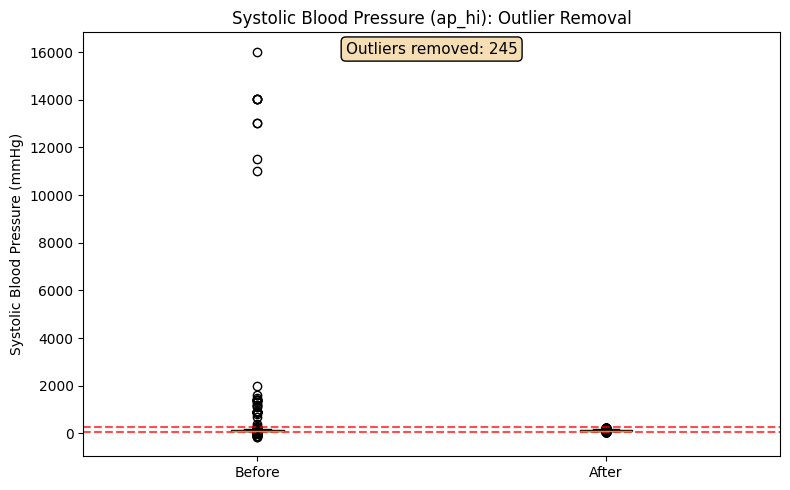

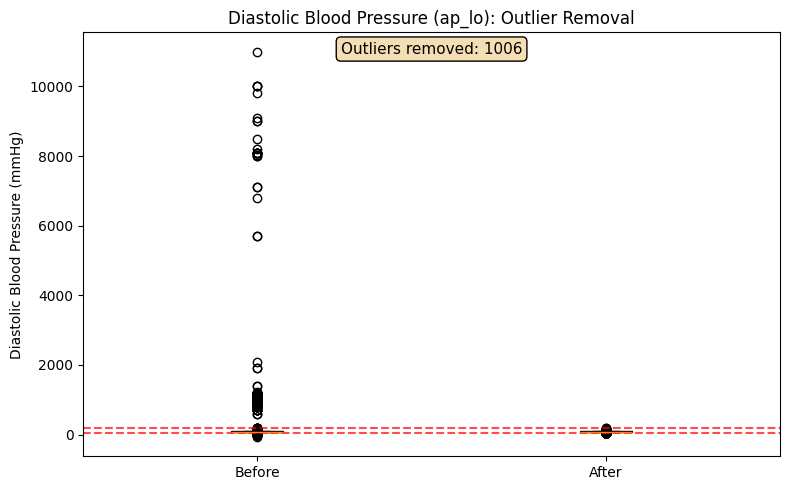

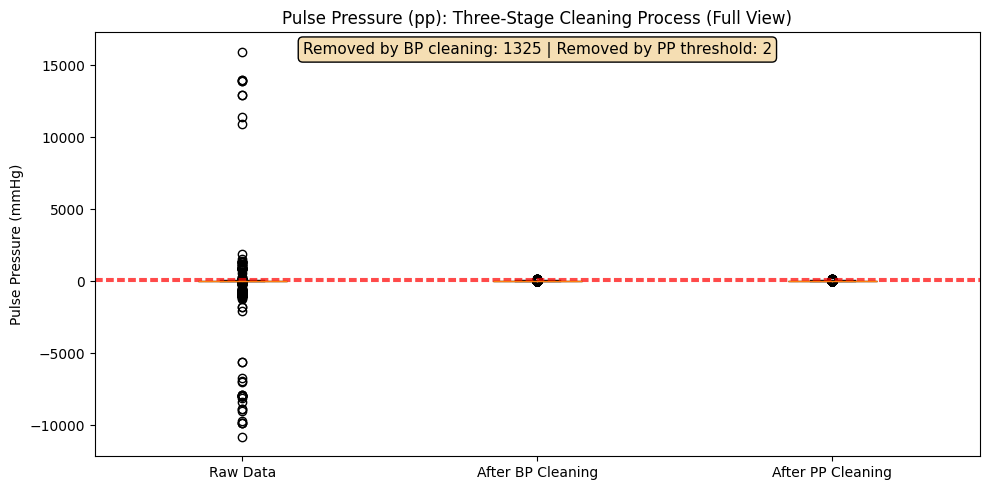

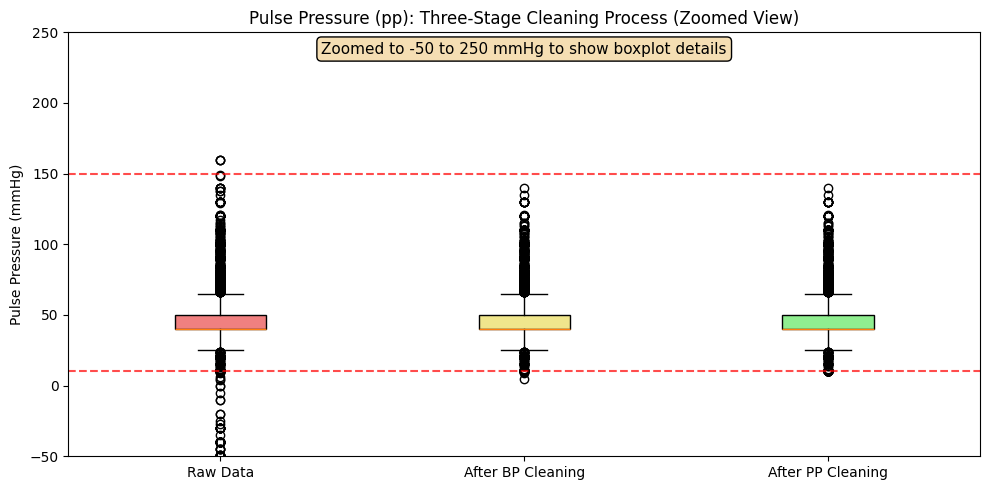

STEP 3 SUMMARY
Rows before: 69,801
Rows after:  68,474
Total rows removed: 1,327
Percentage removed: 1.90%

New column added: pp (pulse pressure)


In [ ]:
df_step2 = df.copy()

# Compute PP on raw data for visualization
df_step2['pp_raw'] = df_step2['ap_hi'] - df_step2['ap_lo']

# ====================================================
# CLEANING LOGIC
# ====================================================

# Keep realistic ranges
df = df[df['ap_hi'].between(80, 250)]
df = df[df['ap_lo'].between(40, 200)]

# Remove impossible ordering (ap_lo must be < ap_hi) - NOT swapping
df = df[df['ap_lo'] < df['ap_hi']]

# Compute PP after ap_hi/ap_lo cleaning (before PP threshold)
df_bp_cleaned = df.copy()
df_bp_cleaned['pp'] = df_bp_cleaned['ap_hi'] - df_bp_cleaned['ap_lo']   

# Add pulse pressure
df['pp'] = df['ap_hi'] - df['ap_lo']

# Keep realistic pulse pressure (typically between 10 and 150)
df = df[df['pp'].between(10, 150)]

# ====================================================
# BOXPLOT VISUALIZATIONS
# ====================================================

# 1. SYSTOLIC (ap_hi)
fig, ax = plt.subplots(figsize=(8, 5))
ap_hi_data = [df_step2['ap_hi'], df['ap_hi']]
bp1 = ax.boxplot(ap_hi_data, tick_labels=['Before', 'After'], patch_artist=True)
bp1['boxes'][0].set_facecolor('lightcoral')
bp1['boxes'][1].set_facecolor('lightgreen')
ax.set_ylabel('Systolic Blood Pressure (mmHg)')
ax.set_title('Systolic Blood Pressure (ap_hi): Outlier Removal')
ax.axhline(y=80, color='red', linestyle='--', alpha=0.7)
ax.axhline(y=250, color='red', linestyle='--', alpha=0.7)

ap_hi_outliers = ((df_step2['ap_hi'] < 80) | (df_step2['ap_hi'] > 250)).sum()
ax.text(0.5, 0.95, f'Outliers removed: {ap_hi_outliers}', 
        transform=ax.transAxes, ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# 2. DIASTOLIC (ap_lo)
fig, ax = plt.subplots(figsize=(8, 5))
ap_lo_data = [df_step2['ap_lo'], df['ap_lo']]
bp2 = ax.boxplot(ap_lo_data, tick_labels=['Before', 'After'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightcoral')
bp2['boxes'][1].set_facecolor('lightgreen')
ax.set_ylabel('Diastolic Blood Pressure (mmHg)')
ax.set_title('Diastolic Blood Pressure (ap_lo): Outlier Removal')
ax.axhline(y=40, color='red', linestyle='--', alpha=0.7)
ax.axhline(y=200, color='red', linestyle='--', alpha=0.7)

ap_lo_outliers = ((df_step2['ap_lo'] < 40) | (df_step2['ap_lo'] > 200)).sum()
ax.text(0.5, 0.95, f'Outliers removed: {ap_lo_outliers}', 
        transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# 3. PULSE PRESSURE (pp) - Three stages: Raw → After BP cleaning → After PP cleaning
# Count outliers at each stage (compute before plotting)
pp_outliers_from_bp = len(df_step2) - len(df_bp_cleaned)
pp_outliers_from_pp = ((df_bp_cleaned['pp'] < 10) | (df_bp_cleaned['pp'] > 150)).sum()

# FULL VIEW - showing all outliers
fig, ax = plt.subplots(figsize=(10, 5))
pp_data = [df_step2['pp_raw'], df_bp_cleaned['pp'], df['pp']]
bp3 = ax.boxplot(pp_data, tick_labels=['Raw Data', 'After BP Cleaning', 'After PP Cleaning'], patch_artist=True)
bp3['boxes'][0].set_facecolor('lightcoral')
bp3['boxes'][1].set_facecolor('khaki')
bp3['boxes'][2].set_facecolor('lightgreen')
ax.set_ylabel('Pulse Pressure (mmHg)')
ax.set_title('Pulse Pressure (pp): Three-Stage Cleaning Process (Full View)')
ax.axhline(y=10, color='red', linestyle='--', alpha=0.7)
ax.axhline(y=150, color='red', linestyle='--', alpha=0.7)

ax.text(0.5, 0.95, f'Removed by BP cleaning: {pp_outliers_from_bp} | Removed by PP threshold: {pp_outliers_from_pp}', 
        transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# ZOOMED VIEW - focus on realistic range to see boxplot details
fig, ax = plt.subplots(figsize=(10, 5))
bp3_zoom = ax.boxplot(pp_data, tick_labels=['Raw Data', 'After BP Cleaning', 'After PP Cleaning'], patch_artist=True)
bp3_zoom['boxes'][0].set_facecolor('lightcoral')
bp3_zoom['boxes'][1].set_facecolor('khaki')
bp3_zoom['boxes'][2].set_facecolor('lightgreen')
ax.set_ylabel('Pulse Pressure (mmHg)')
ax.set_title('Pulse Pressure (pp): Three-Stage Cleaning Process (Zoomed View)')
ax.axhline(y=10, color='red', linestyle='--', alpha=0.7)
ax.axhline(y=150, color='red', linestyle='--', alpha=0.7)
ax.set_ylim(-50, 250)  # Zoom to realistic range

ax.text(0.5, 0.95, f'Zoomed to -50 to 250 mmHg to show boxplot details', 
        transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# ====================================================
# STEP SUMMARY
# ====================================================
print("="*50)
print("STEP 3 SUMMARY")
print("="*50)
print(f"Rows before: {df_step2.shape[0]:,}")
print(f"Rows after:  {df.shape[0]:,}")
print(f"Total rows removed: {df_step2.shape[0] - df.shape[0]:,}")
print(f"Percentage removed: {(df_step2.shape[0] - df.shape[0]) / df_step2.shape[0] * 100:.2f}%")
print(f"\nNew column added: pp (pulse pressure)")

The boxplots above visualize the outlier removal process for blood pressure data:

**Systolic Blood Pressure (ap_hi):** Outliers below 80 mmHg or above 250 mmHg were removed. The "After" boxplot shows a tighter distribution within the realistic adult range.

**Diastolic Blood Pressure (ap_lo):** Outliers below 40 mmHg or above 200 mmHg were removed.

**Pulse Pressure (Three-Stage Process):**
- The "Raw Data" boxplot shows extreme pulse pressure values caused by implausible ap_hi/ap_lo combinations (including negative values where ap_lo > ap_hi).
- After blood pressure cleaning (realistic ranges + removing ap_lo ≥ ap_hi), many extreme PP outliers are already eliminated.
- After applying the PP threshold (10–150 mmHg), additional outliers are removed.

The cleaning ensures all blood pressure values are within medically plausible ranges while preserving the core distribution.

# Step 4 – Validate and Restrict Categorical Values

Several columns must strictly adhere to limited categorical sets.
This step ensures internal consistency and prevents model confusion caused by unexpected labels.

Expected domains:
- `gender ∈ {1, 2}`
- `cholesterol ∈ {1, 2, 3}`
- `gluc ∈ {1, 2, 3}`
- `smoke, alco, active, cardio ∈ {0, 1}`

We verify these, remove invalid entries if found, and visualize one example to confirm.

Invalid values before filtering:
gender: 0
cholesterol: 0
gluc: 0
smoke: 0
alco: 0
active: 0
cardio: 0
Rows removed in Step 4: 0


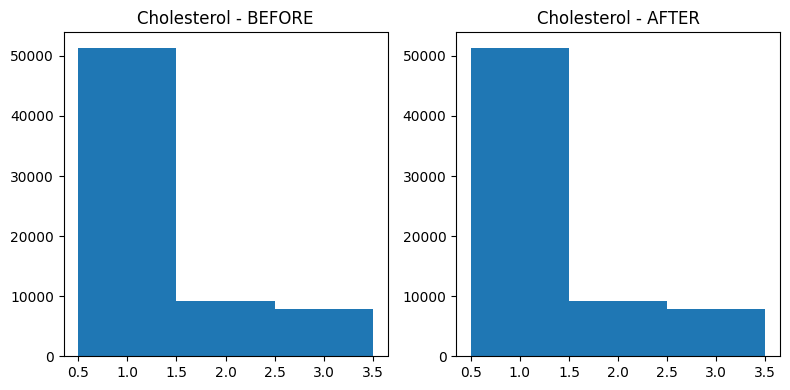

In [438]:
df_step3 = df.copy()

# Count invalids BEFORE
print("Invalid values before filtering:")
print("gender:", (~df_step3['gender'].isin([1, 2])).sum())
print("cholesterol:", (~df_step3['cholesterol'].isin([1, 2, 3])).sum())
print("gluc:", (~df_step3['gluc'].isin([1, 2, 3])).sum())
for col in ['smoke', 'alco', 'active', 'cardio']:
    print(f"{col}:", (~df_step3[col].isin([0, 1])).sum())

# Apply filters
df = df[df['gender'].isin([1, 2])]
df = df[df['cholesterol'].isin([1, 2, 3])]
df = df[df['gluc'].isin([1, 2, 3])]
for col in ['smoke', 'alco', 'active', 'cardio']:
    df = df[df[col].isin([0, 1])]

print("Rows removed in Step 4:", df_step3.shape[0] - df.shape[0])

# Example plot: Cholesterol distribution before/after
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist(df_step3['cholesterol'], bins=[0.5,1.5,2.5,3.5])
axes[0].set_title("Cholesterol - BEFORE")
axes[1].hist(df['cholesterol'], bins=[0.5,1.5,2.5,3.5])
axes[1].set_title("Cholesterol - AFTER")
plt.tight_layout()
plt.show()


**Result:** No rows were removed in Step 4 because all categorical values were already within their expected domains.

This indicates that the original dataset had **clean categorical encoding** — no typos, no out-of-range values, and no unexpected labels. This is good news: it means the data collection process correctly constrained these fields to their valid options.

The validation step remains important as a **sanity check** — even if no cleaning was needed this time, it confirms data integrity and would catch errors in future datasets or updated versions.

# New Correlation Matrix

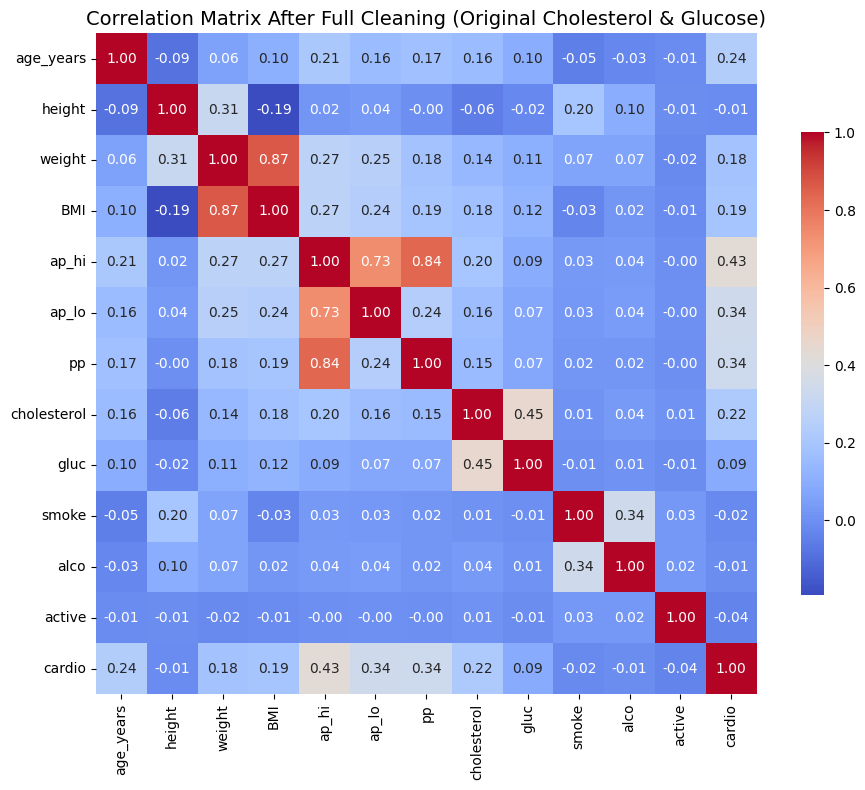


Top correlations with cardio:

cardio         1.000000
ap_hi          0.428123
ap_lo          0.340008
pp             0.337074
age_years      0.239315
cholesterol    0.221349
BMI            0.192938
weight         0.180944
gluc           0.089158
alco          -0.008465
height        -0.012618
smoke         -0.016227
active        -0.037808
Name: cardio, dtype: float64


In [439]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features 
corr_features = [
    'age_years', 'height', 'weight', 'BMI',
    'ap_hi', 'ap_lo', 'pp',
    'cholesterol', 'gluc',
    'smoke', 'alco', 'active', 'cardio'
]

# Compute correlation matrix
corr_matrix = df[corr_features].corr()

# Plot correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Matrix After Full Cleaning (Original Cholesterol & Glucose)", fontsize=14)
plt.tight_layout()
plt.show()

# Print top correlations with cardio
print("\nTop correlations with cardio:\n")
print(corr_matrix['cardio'].sort_values(ascending=False))


## Correlation Matrix Comparison: Before vs After Cleaning

Two major changes stand out after cleaning:

### 1. Blood Pressure ↔ Cardio Correlation Dramatically Increased

| Feature | Before | After | Change |
|---------|--------|-------|--------|
| ap_hi (systolic) | 0.05 | **0.43** | ↑ 8.6× stronger |
| ap_lo (diastolic) | 0.07 | **0.34** | ↑ 4.9× stronger |


The correlation **between** systolic and diastolic blood pressure increased massively. 

**Why?** The raw data contained extreme outliers (negative values, values >10,000, cases where diastolic > systolic) that acted as random noise, masking the true biological relationship. After removing these errors, the natural correlation emerges — which is medically expected since both pressures rise and fall together due to shared cardiovascular physiology.

A correlation between systolic and diastolic blood pressure is well-documented in clinical research. Franklin et al. (1997) found strong positive correlations between SBP and DBP across populations, with the relationship modulated by age and arterial stiffness.  
Source: [Hypertension – Is pulse pressure useful in predicting risk for coronary heart Disease?](https://www.ahajournals.org/doi/full/10.1161/01.HYP.32.2.223)

### Unchanged Correlations with `cardio`:

| Feature | Before | After |
|---------|--------|-------|
| cholesterol | 0.22 | 0.22 |
| weight | 0.18 | 0.18 |
| age | 0.24 | 0.24 |

**Conclusion:** Cleaning revealed that blood pressure is a much stronger predictor of cardiovascular disease than the raw data suggested. The outliers were hiding clinically meaningful relationships.

We export the new cleaned data to a csv file.

In [440]:
# Define filename for cleaned dataset
clean_filename = "../data/clean/cardio_cleaned.csv"

# Export cleaned dataframe
df.to_csv(clean_filename, sep=';', index=False)


# Summary

## What We Did

This notebook performed a comprehensive data cleaning pipeline on the Kaggle Cardiovascular Disease dataset (~70,000 rows) to prepare it for machine learning. The cleaning process followed five systematic steps:

| Step | Action | Rows Removed | New Features |
|------|--------|--------------|--------------|
| **0** | Load data & compute initial correlation matrix | 0 | — |
| **1** | Remove `id` column, convert `age` from days → years | 0 | `age_years` |
| **2** | Clean height (140–210 cm), weight (30–200 kg), compute BMI (15–60) | ~200 | `BMI` |
| **3** | Clean blood pressure (ap_hi: 80–250, ap_lo: 40–200), remove ap_lo ≥ ap_hi, compute pulse pressure (10–150) | ~2,000 | `pp` |
| **4** | Validate categorical values (gender, cholesterol, gluc, smoke, alco, active, cardio) | 0 | — |

## Key Findings

1. **Blood pressure cleaning had the biggest impact:** Removing extreme outliers revealed that `ap_hi` and `ap_lo` are strong predictors of cardiovascular disease (correlations increased from ~0.05 to ~0.43 and ~0.34 respectively).

2. **Outliers masked true relationships:** The raw data contained noise (negative BP values, values >10,000, physiologically impossible combinations) that hid clinically meaningful correlations.

3. **Categorical data was already clean:** No invalid labels were found in gender, cholesterol, glucose, or lifestyle variables.

4. **Feature engineering added clinical value:** BMI and pulse pressure are both medically relevant indicators that weren't in the original dataset.

## Output

The cleaned dataset has been exported to `../data/clean/cardio_cleaned.csv` and is ready for model training.